<img src="images/logos/esgf2-us.png" width=250 alt="ESGF logo"></img>

# Complex Searching with `intake` and analysing employing `xarray` 

## Overview

This tutorial we will present access multiple historical (as an example here) data available and analyze  using `intake`. Put them in a dictionary format employing `xarray` and plotting simple area average time series over a specific region. 

## Imports

In [15]:
import warnings
import intake
from distributed import Client
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import dask
xr.set_options(display_style='html')
warnings.filterwarnings("ignore")

In [16]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [17]:
cat = col.search(experiment_id=["historical"],
    variable_id = ["tas"],
    member_id = ["r1i1p1f1"],
    table_id = ["Amon",], 
    source_id = [ "CMCC-ESM2", "CanESM5", "CESM2", "CESM2-FV2", ]
)

In [18]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
1,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
2,CMIP,NCAR,CESM2-FV2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20191120
3,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-ESM2/historica...,NaN,20210114


In [19]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CMCC.CMCC-ESM2.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn']

In [20]:
ds = {}

for key in dset_dict.keys():
    # Sort the dataset by time
    sorted_dataset = dset_dict[key].sortby("time")
    
    # Subset data for years 1900-2000
    ds[key] = sorted_dataset.sel(time=slice("1900", "2000"))
        
    # Optional: Print a message indicating dataset processing
    print(f"Processing dataset: {key}")


Processing dataset: CMIP.CMCC.CMCC-ESM2.historical.Amon.gn
Processing dataset: CMIP.CCCma.CanESM5.historical.Amon.gn
Processing dataset: CMIP.NCAR.CESM2-FV2.historical.Amon.gn
Processing dataset: CMIP.NCAR.CESM2.historical.Amon.gn


**`ds` now contains subset of datasets for each key in dset_dict** 

**Let's check ds**

In [21]:
ds

{'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn': <xarray.Dataset> Size: 268MB
 Dimensions:         (lat: 192, bnds: 2, lon: 288, member_id: 1,
                      dcpp_init_year: 1, time: 1212)
 Coordinates:
     height          float64 8B ...
   * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
     lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
   * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
     lon_bnds        (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
   * time            (time) object 10kB 1900-01-16 12:00:00 ... 2000-12-16 12:...
     time_bnds       (time, bnds) object 19kB dask.array<chunksize=(1212, 2), meta=np.ndarray>
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) float64 8B nan
 Dimensions without coordinates: bnds
 Data variables:
     tas             (member_id, dcpp_init_year, time, lat, lon) float32 268

### Calculate regional mean for each dataset and visualizing time series

In [22]:
regn_mean = {} 
for key in dset_dict.keys():
    regn_mean[key] = ds[key]['tas'].sel(lon=slice(65, 100), lat=slice(5, 25)).mean(dim=['lon', 'lat']).squeeze()


In [23]:
regn_mean

{'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn': <xarray.DataArray 'tas' (time: 1212)> Size: 5kB
 dask.array<getitem, shape=(1212,), dtype=float32, chunksize=(404,), chunktype=numpy.ndarray>
 Coordinates:
     height          float64 8B ...
   * time            (time) object 10kB 1900-01-16 12:00:00 ... 2000-12-16 12:...
     member_id       <U8 32B 'r1i1p1f1'
     dcpp_init_year  float64 8B nan,
 'CMIP.CCCma.CanESM5.historical.Amon.gn': <xarray.DataArray 'tas' (time: 1212)> Size: 5kB
 dask.array<getitem, shape=(1212,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
 Coordinates:
     height          float64 8B ...
   * time            (time) object 10kB 1900-01-16 12:00:00 ... 2000-12-16 12:...
     member_id       <U8 32B 'r1i1p1f1'
     dcpp_init_year  float64 8B nan,
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn': <xarray.DataArray 'tas' (time: 1212)> Size: 5kB
 dask.array<getitem, shape=(1212,), dtype=float32, chunksize=(822,), chunktype=numpy.ndarray>
 Coordinates:
   * time     

In [24]:
plt.rcParams['figure.figsize'] = [15, 4]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'bold'


#### Visualizing the regional mean for each dataset

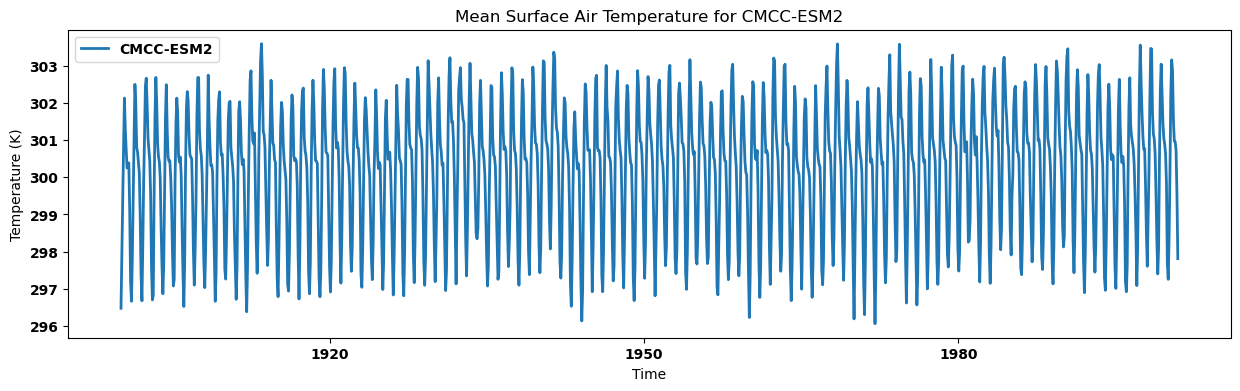

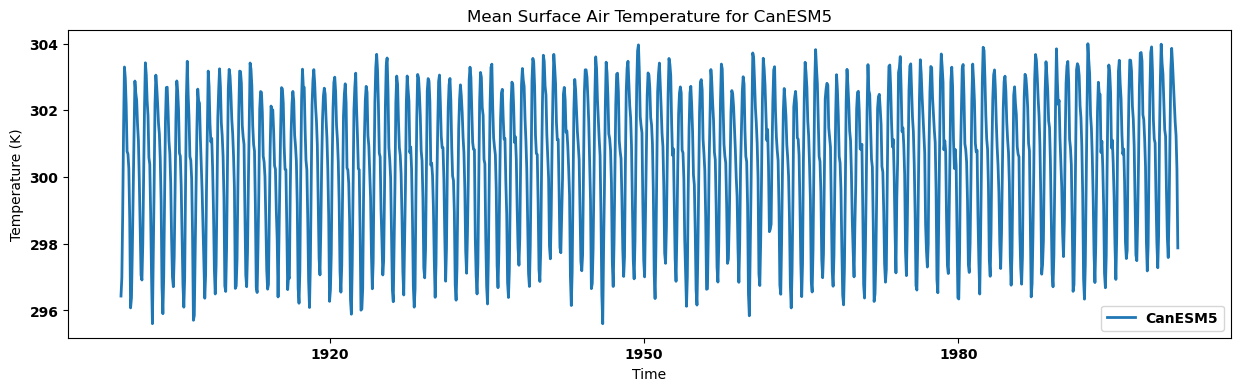

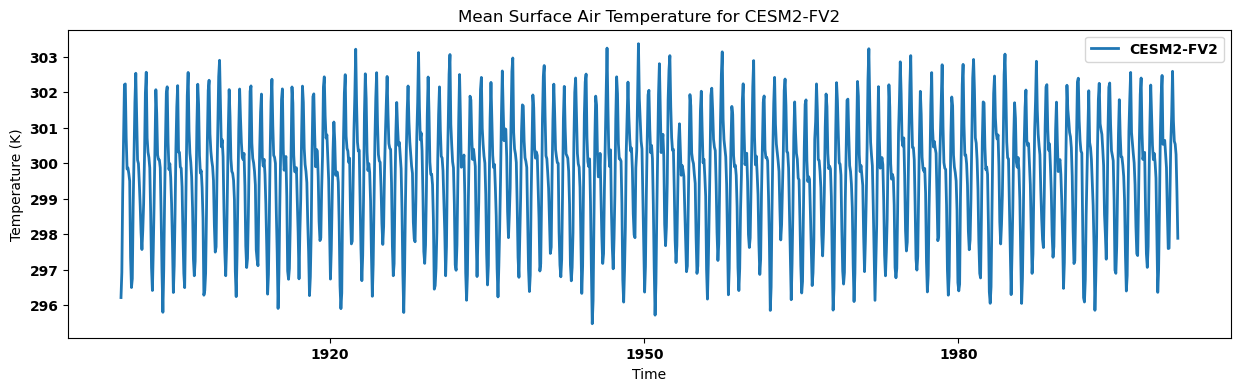

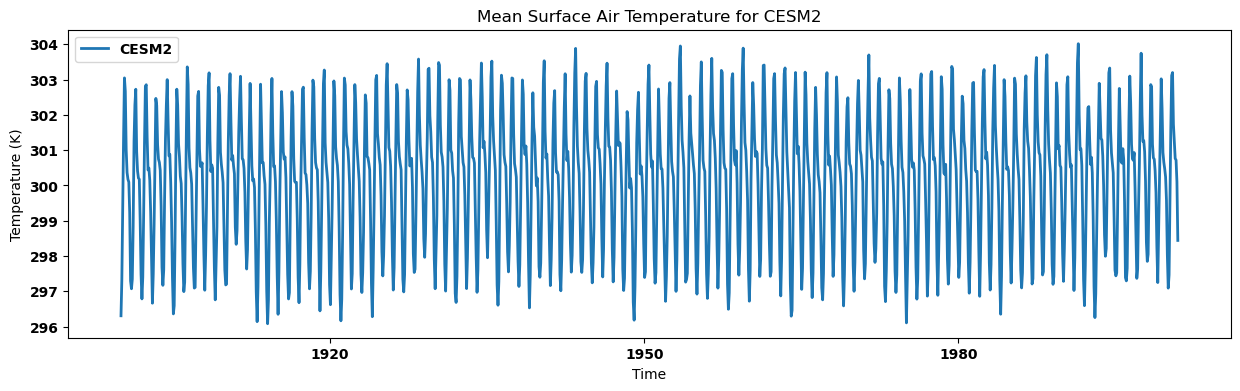

In [25]:
for key, regm in regn_mean.items():
    source_id = key.split('.')[2]
    regm.plot(label=source_id)
    plt.title(f"Mean Surface Air Temperature for {source_id}")
    plt.xlabel('Time')
    plt.ylabel('Temperature (K)')
    plt.legend()
    plt.show()

### Calculating annual mean for each dataset  and visualizing time series

In [26]:
annual_mean = {}
for key, regm in regn_mean.items():
    annual_mean[key] = regm.resample(time='Y').mean()


In [27]:
annual_mean

{'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn': <xarray.DataArray 'tas' (time: 101)> Size: 404B
 dask.array<stack, shape=(101,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height          float64 8B ...
     member_id       <U8 32B 'r1i1p1f1'
     dcpp_init_year  float64 8B nan
   * time            (time) object 808B 1900-12-31 00:00:00 ... 2000-12-31 00:...,
 'CMIP.CCCma.CanESM5.historical.Amon.gn': <xarray.DataArray 'tas' (time: 101)> Size: 404B
 dask.array<stack, shape=(101,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height          float64 8B ...
     member_id       <U8 32B 'r1i1p1f1'
     dcpp_init_year  float64 8B nan
   * time            (time) object 808B 1900-12-31 00:00:00 ... 2000-12-31 00:...,
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn': <xarray.DataArray 'tas' (time: 101)> Size: 404B
 dask.array<stack, shape=(101,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     member_id       <U8 32B 

#### Visualizing the regional annual mean for each dataset

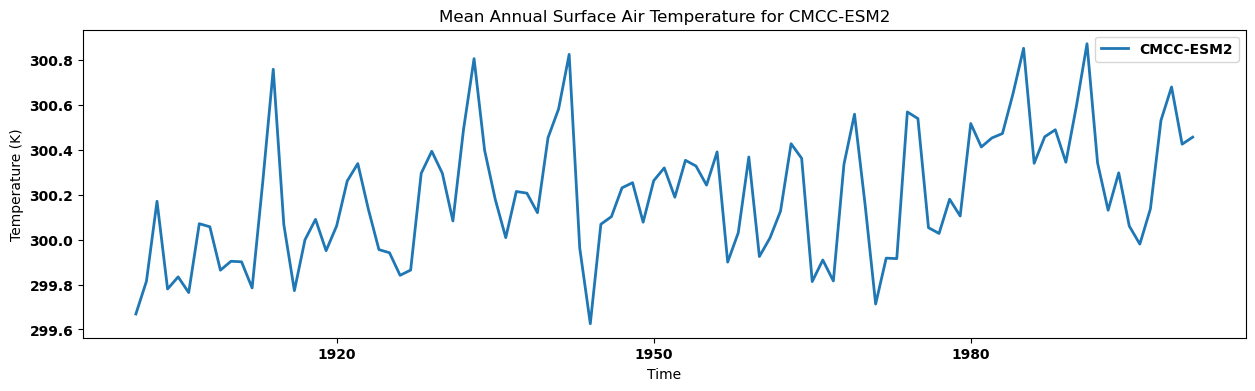

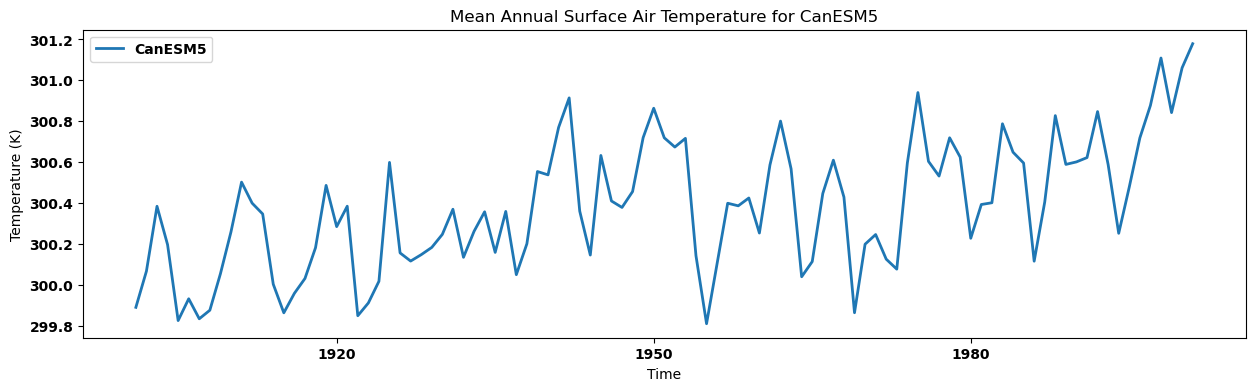

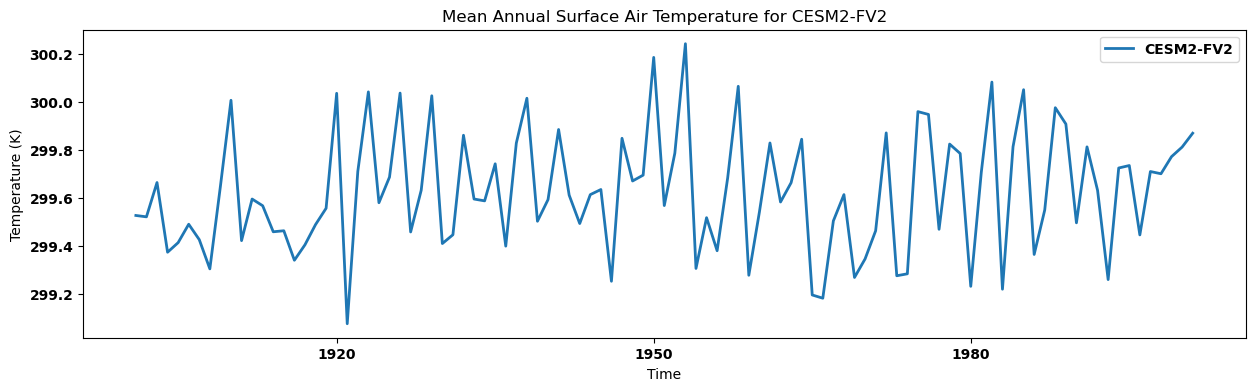

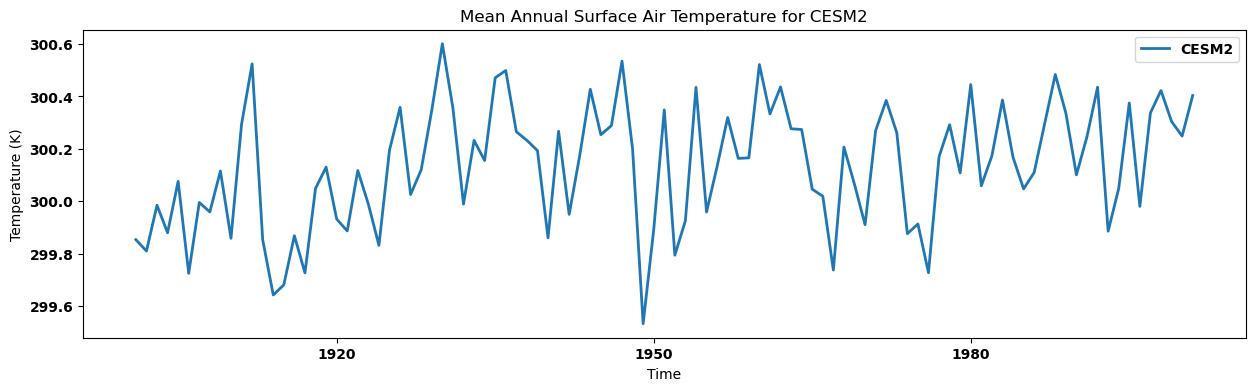

In [28]:
for key, anmn in annual_mean.items():
    source_id = key.split('.')[2]
    anmn.plot(label=source_id)
    plt.title(f"Mean Annual Surface Air Temperature for {source_id}")
    plt.xlabel('Time')
    plt.ylabel('Temperature (K)')
    plt.legend()
    plt.show()

#### Visualizing the regional annual mean for each dataset in a single panel


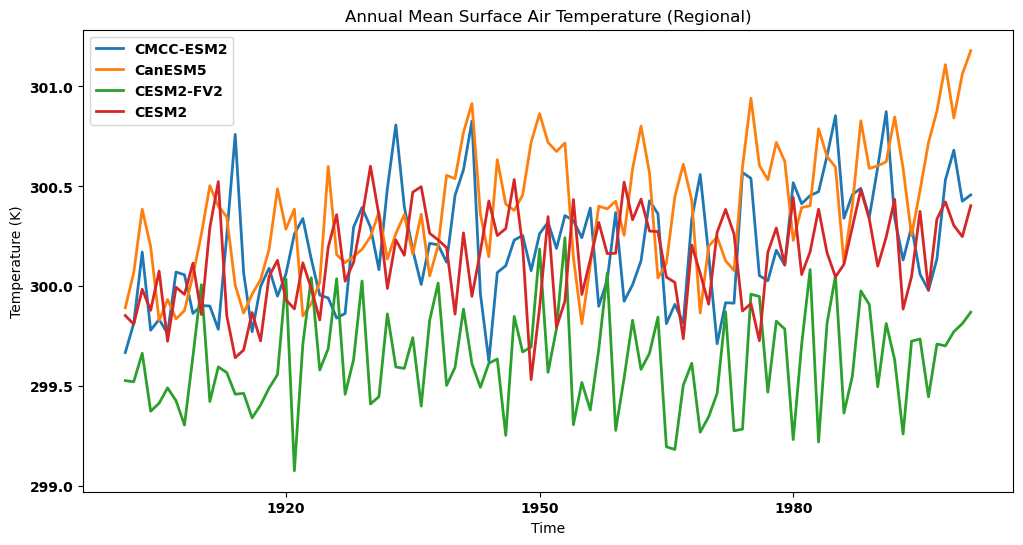

In [29]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plotting the annual mean for each dataset on the same plot
for key, annm in annual_mean.items():
    source_id = key.split('.')[2]
    annm.plot(label=source_id)

plt.title("Annual Mean Surface Air Temperature (Regional)")
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()


### References 
[Global Mean Surface Temperature](https://projectpythia.org/cmip6-cookbook/notebooks/example-workflows/gmst.html)